## Make Classification data

In [53]:
import sklearn

In [54]:
from sklearn.datasets import make_circles

n_samples = 1000

# Create circles
X, y =  make_circles(n_samples,
                     noise = 0.03,
                     random_state=42)

len(X), len(y)

(1000, 1000)

In [55]:
print(X[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [56]:
print(y[:5])

[1 1 1 1 0]


In [57]:
# Make dataframe
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label":y
                        })
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


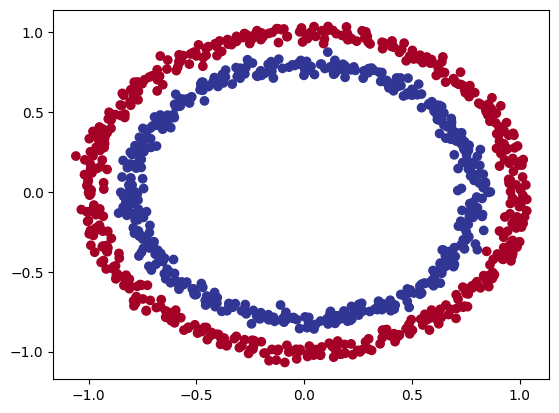

In [58]:
# visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu);

### Check input and output shapes

In [59]:
X.shape, y.shape

((1000, 2), (1000,))

In [60]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [61]:
# View first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(X_sample, X_sample.shape)
print(y_sample, y_sample.shape)

[0.75424625 0.23148074] (2,)
1 ()


### Turn Data into Tensors

In [62]:
# Turn data into tensors
import torch
from torch import nn
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [63]:
X[:5], y[:5], y.dtype

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]),
 torch.float32)

In [64]:
torch.manual_seed(42)

In [65]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape

(torch.Size([800, 2]), torch.Size([200, 2]))

### 2. Building a model

In [66]:
# Import libs
import torch
from torch import nn


In [67]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [68]:
## Construct a model

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1)

  def forward(self, x):
    ## x --> layer_1 --> layer_2
    return self.layer_2(self.layer_1(x))


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [69]:
next(model_0.parameters()).device

device(type='cpu')

In [70]:
## Replicating the model using sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [71]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [72]:
# Make Predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions : {len(untrained_preds)}, Shape : {untrained_preds.shape}")
print(f"Length of predictions : {len(X_test)}, Shape : {X_test.shape}")
print(f"\nFirst 10 predictions :\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels :\n{y_test[:10]}")


Length of predictions : 200, Shape : torch.Size([200, 1])
Length of predictions : 200, Shape : torch.Size([200, 2])

First 10 predictions :
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]])

First 10 labels :
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Loss Functions and Optimizer Functions

In [73]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)


In [74]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 3.Train model

### 3.1 Going from raw logits --> Prediction Probs -->  Predictions Labels


In [75]:
# View first 5 op of forward pass on test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [76]:
# Use the sigmoid on logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

In [77]:
# Find predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dims
y_preds.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        0., 1.])

### 3.2 Training and Testing Loop

In [78]:
torch.manual_seed(42)

torch.cuda.manual_seed(42)

# Epochs
epochs = 100

# Put the data to traget device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [79]:
# Build the training and testing evaluation loop
for epoch in range(epochs)  :
  ## Traning
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss / accuracy
  # nn.BCE expects probs
  # loss = loss_fn(torch.sigmoid(y_logits), y_train)

  ## nn.BCEWithLogitsloss expects logits
  loss = loss_fn(y_logits,
                 y_train)

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing
  model_0.eval()

  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()

    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)
  # Print out whats happening
  if epoch % 10 == 0 :
    print(f"Epoch : {epoch} | Loss : {loss: .5f}  | Acc:{acc:.2f}% \
      | Test Loss : {test_loss:.5f}  | Test Acc : {test_acc:.2f}%\
    ")

Epoch : 0 | Loss :  0.69796  | Acc:51.88%       | Test Loss : 0.69440  | Test Acc : 58.00%    
Epoch : 10 | Loss :  0.69590  | Acc:51.25%       | Test Loss : 0.69305  | Test Acc : 53.00%    
Epoch : 20 | Loss :  0.69490  | Acc:51.62%       | Test Loss : 0.69254  | Test Acc : 49.50%    
Epoch : 30 | Loss :  0.69435  | Acc:51.12%       | Test Loss : 0.69236  | Test Acc : 49.50%    
Epoch : 40 | Loss :  0.69401  | Acc:50.88%       | Test Loss : 0.69232  | Test Acc : 51.00%    
Epoch : 50 | Loss :  0.69378  | Acc:50.25%       | Test Loss : 0.69234  | Test Acc : 50.00%    
Epoch : 60 | Loss :  0.69362  | Acc:50.00%       | Test Loss : 0.69239  | Test Acc : 51.50%    
Epoch : 70 | Loss :  0.69351  | Acc:50.25%       | Test Loss : 0.69246  | Test Acc : 51.00%    
Epoch : 80 | Loss :  0.69342  | Acc:49.88%       | Test Loss : 0.69254  | Test Acc : 50.00%    
Epoch : 90 | Loss :  0.69336  | Acc:49.88%       | Test Loss : 0.69262  | Test Acc : 53.00%    


## 4.Make Predictions


In [80]:
import requests

In [81]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


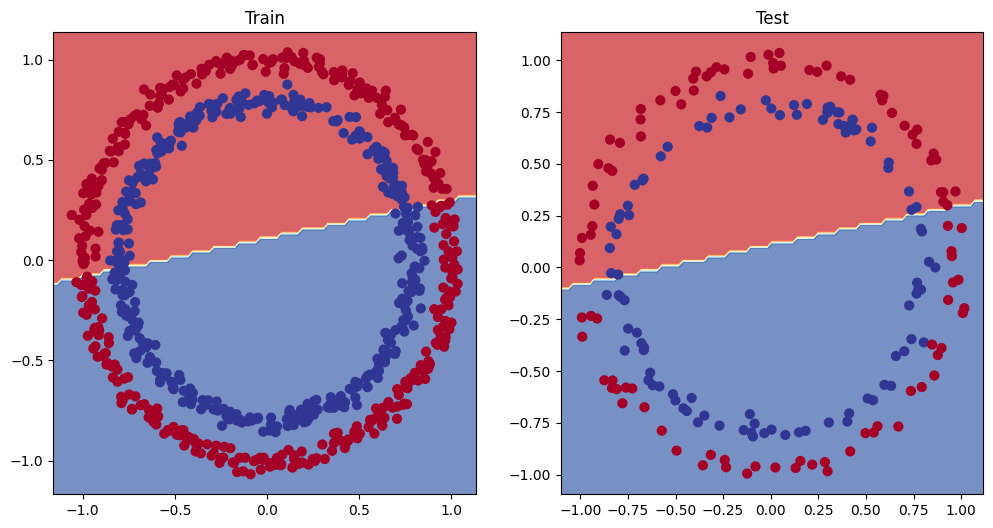

In [82]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5.Improving the model

In [83]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [84]:
# create a loss functions
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(lr = 0.1,
                            params=model_1.parameters())


In [85]:
# Write training and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Epochs
epochs = 1000

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()


  ### Testing
  model_1.eval()

  with torch.inference_mode():
    test_logits  = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  # whats happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss:.5f},  Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.69396,  Test loss: 0.69261
Epoch: 100 | Train loss: 0.69305,  Test loss: 0.69379
Epoch: 200 | Train loss: 0.69299,  Test loss: 0.69437
Epoch: 300 | Train loss: 0.69298,  Test loss: 0.69458
Epoch: 400 | Train loss: 0.69298,  Test loss: 0.69465
Epoch: 500 | Train loss: 0.69298,  Test loss: 0.69467
Epoch: 600 | Train loss: 0.69298,  Test loss: 0.69468
Epoch: 700 | Train loss: 0.69298,  Test loss: 0.69468
Epoch: 800 | Train loss: 0.69298,  Test loss: 0.69468
Epoch: 900 | Train loss: 0.69298,  Test loss: 0.69468


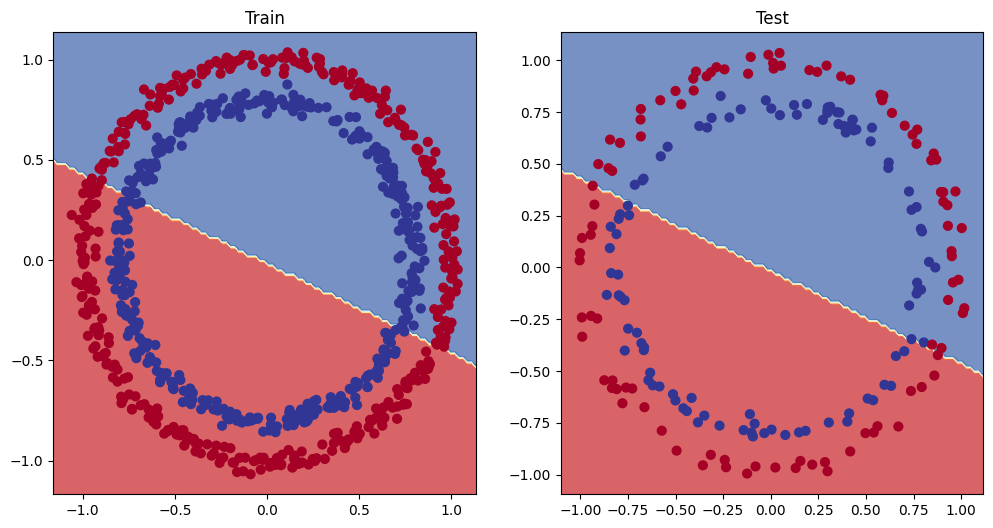

In [86]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can model a straight line

In [87]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

### 5.2 Adjusting model_1 to fit a straight line

In [88]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


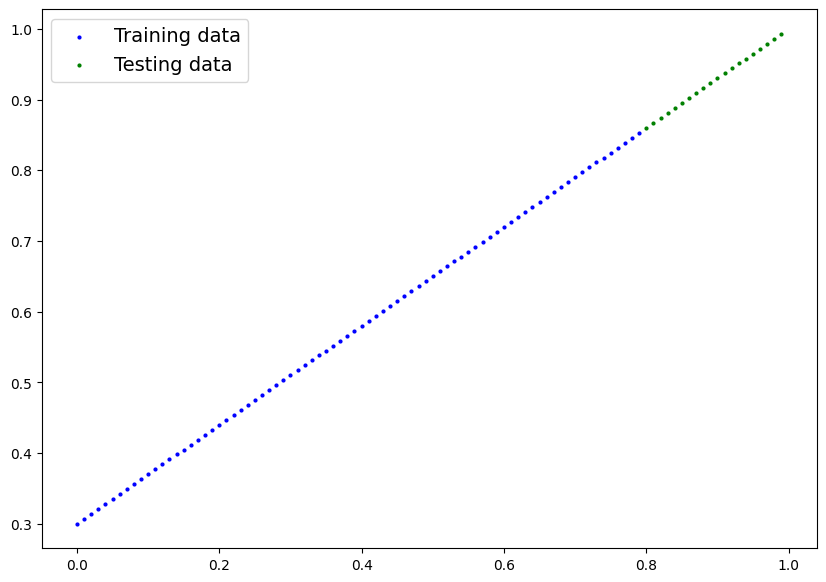

In [89]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [90]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [91]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [92]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


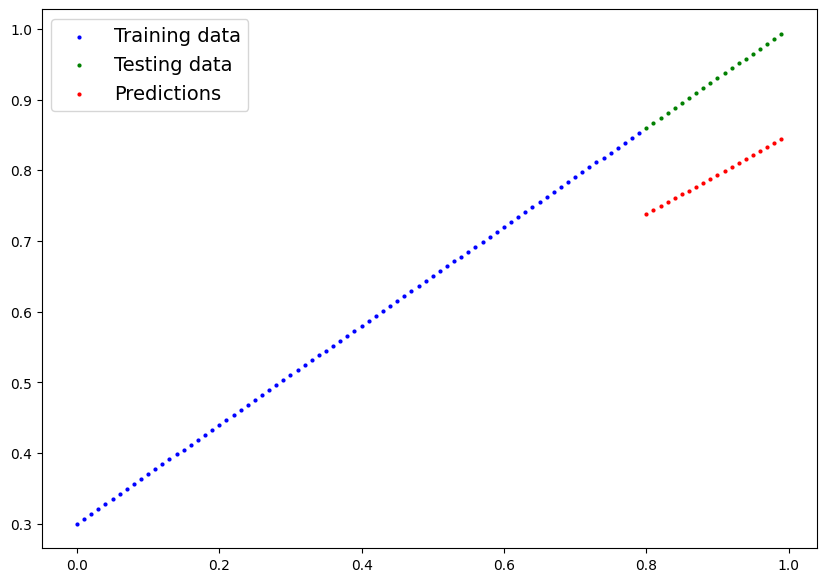

In [93]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6.The missing piece: non-linearity

### 6.1 Recreating non-linear data

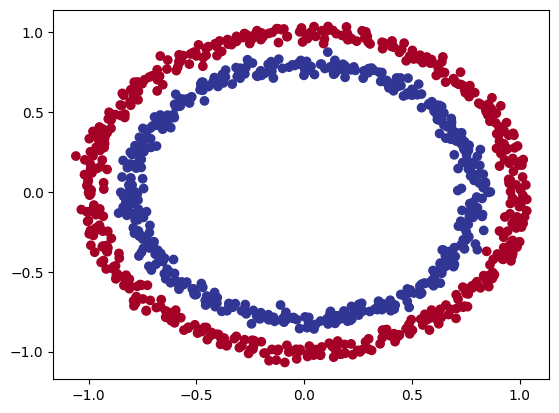

In [94]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [95]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [96]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [97]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [98]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%



### 6.4 Evaluating a model trained with non-linear activation functions

In [99]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

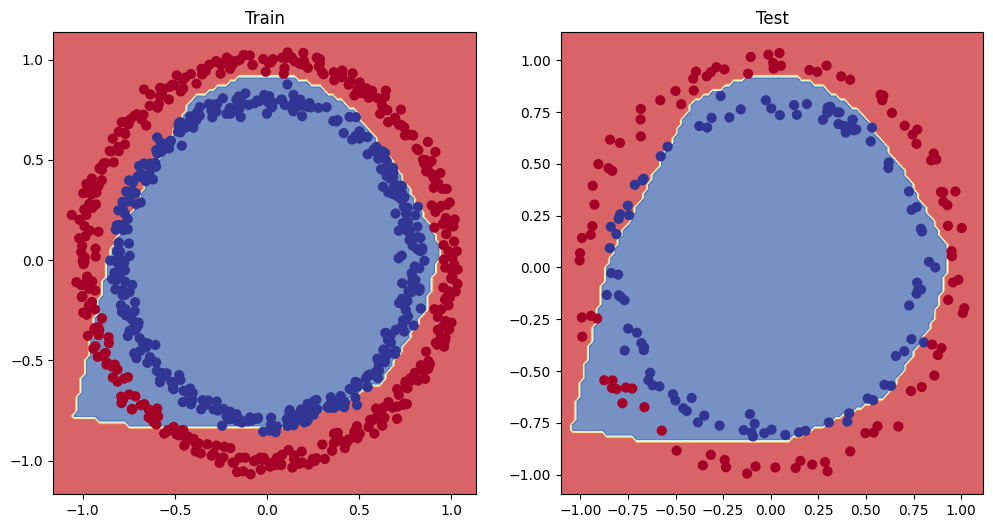

In [100]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 8.Putting things together by building a multi-class PyTorch model

### 8.1 Creating multi-class classification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


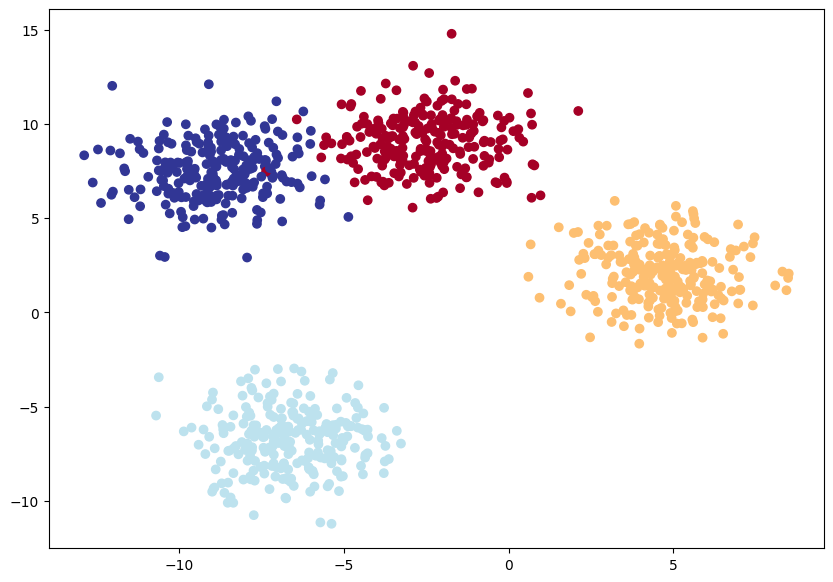

In [101]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [102]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [105]:
## Multiclass Classification Model

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initialized multi class classification model

    Args:
      input_features (int): Number of input features to model
      output_features (int): Number of output features from model
      hidden_units (int): Number of hidden units between layers

    Returns:
      Model architecture
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_features)
      )


  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [106]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [107]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-0.2423, -0.2527, -0.0958,  0.5969],
        [-0.0444,  0.0316,  0.4448, -0.0867],
        [-0.2068, -0.1211,  1.3304, -0.3413],
        [-0.1453, -0.0848,  0.8602, -0.1945],
        [-0.0558,  0.0409,  0.4359, -0.0724]], grad_fn=<SliceBackward0>)

In [108]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [109]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.2808, -0.1917, -0.0700,  0.5581],
        [ 0.2334, -0.2277,  0.6167, -0.4486],
        [-0.3333,  0.0639,  1.0439, -0.2317],
        [-0.2139, -0.1545,  0.0168,  0.4633],
        [-0.1981,  0.0649,  0.2720,  0.1182]], grad_fn=<SliceBackward0>)
tensor([[0.1773, 0.1938, 0.2188, 0.4101],
        [0.2775, 0.1750, 0.4071, 0.1403],
        [0.1323, 0.1968, 0.5244, 0.1465],
        [0.1891, 0.2006, 0.2381, 0.3722],
        [0.1896, 0.2467, 0.3035, 0.2602]], grad_fn=<SliceBackward0>)


In [110]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [111]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1773, 0.1938, 0.2188, 0.4101], grad_fn=<SelectBackward0>)
tensor(3)


### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [112]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.49387, Acc: 24.62% | Test Loss: 1.34894, Test Acc: 26.50%
Epoch: 10 | Loss: 0.74638, Acc: 74.88% | Test Loss: 0.67561, Test Acc: 75.50%
Epoch: 20 | Loss: 0.45365, Acc: 94.75% | Test Loss: 0.41840, Test Acc: 99.00%
Epoch: 30 | Loss: 0.21121, Acc: 99.12% | Test Loss: 0.19333, Test Acc: 99.50%
Epoch: 40 | Loss: 0.10520, Acc: 99.25% | Test Loss: 0.09569, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06927, Acc: 99.12% | Test Loss: 0.06170, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05387, Acc: 99.12% | Test Loss: 0.04663, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04567, Acc: 99.12% | Test Loss: 0.03834, Test Acc: 99.50%
Epoch: 80 | Loss: 0.04067, Acc: 99.12% | Test Loss: 0.03313, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03733, Acc: 99.12% | Test Loss: 0.02956, Test Acc: 99.50%


In [113]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-1.0645,  5.0013, -3.0173, -1.7678],
        [-0.6063, -3.9140, -1.3866,  4.7700],
        [-4.9827, -3.9660,  9.0281,  2.1342],
        [-0.8584,  3.8891, -2.2346, -1.3586],
        [ 4.5859, -1.6211, -4.9178, -0.4122],
        [-1.0176, -4.9519, -1.3435,  5.9697],
        [-4.3026, -3.2897,  8.0061,  1.2764],
        [ 5.1555, -2.6458, -4.6941, -0.1440],
        [-6.2766, -5.2568, 11.1296,  3.4506],
        [ 5.0398, -2.5702, -4.5896, -0.1481]])

In [114]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


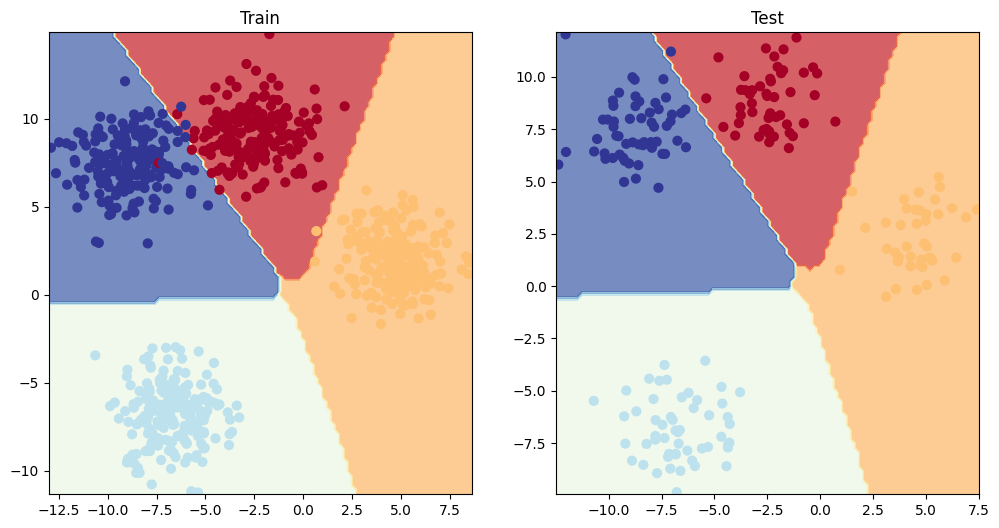

In [115]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)